In [21]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize, Bounds, OptimizeResult
from ECIRModel import ECIRModel
import sys; sys.path.insert(0, '..')
from scipy.optimize import Bounds

In [22]:
 class Calibration:
    """Class for calibrating interest rate models with MLE."""
    def __init__(self, data, dt, model_class, initial_params):
        self.data = data
        self.dt = dt
        self.model_class = model_class
        self.initial_params = initial_params.copy()

    def _nlog_likelihood(self, params: tuple, *args) -> float:
        """Calculates the negative log likelihood for given parameter values."""
        model_params = self.initial_params.copy()
        model_params.update(dict(zip(args, params)))
        model = self.model_class(**model_params)  
        loglikelihood = 0
        for i in range(len(self.data) - 1):
            transition_prob = model.transition_density(
                rt=self.data.iloc[i + 1], 
                rt_1=self.data.iloc[i],   
                dt=self.dt
            )
            if transition_prob <= 0:
                return float('inf')  # Handling non-positive transition probabilities
            loglikelihood += np.log(transition_prob)
        return -loglikelihood


    def calibrate(self, bounds: Bounds, params) -> OptimizeResult:
        """Calculate optimal parameter values."""
        initial_values = [self.initial_params[param] for param in params]
        result = minimize(
            self._nlog_likelihood,
            initial_values,
            args=params,
            method='L-BFGS-B',
            bounds=bounds)
        return result

<Axes: xlabel='DATE'>

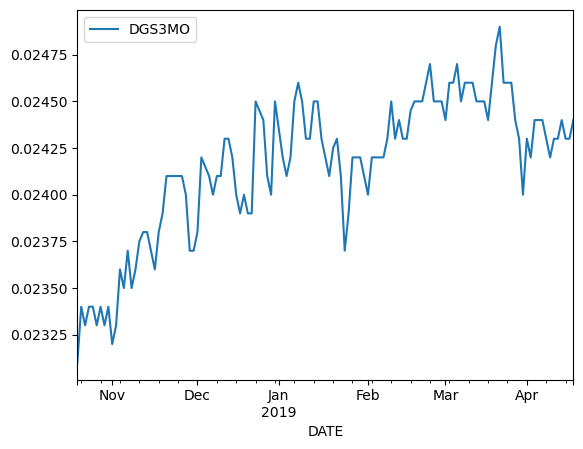

In [23]:
# calibrate using 3mon treasury bill YTM for the past 6 months
df_1_yc = pd.read_csv("Data Folder/DGS3MO.csv")

# data cleaning
df_1_yc.index = pd.to_datetime(df_1_yc.DATE)
df_1_yc = df_1_yc.dropna().drop(columns=["DATE"])
df_1_yc.DGS3MO = df_1_yc.DGS3MO.replace(".", np.nan).astype(float)/100
df_1_yc = df_1_yc.dropna()

# filter out calibration period
df_1_yc = df_1_yc['2018-10-19':'2019-4-17']

df_1_yc.plot()

In [24]:
# Initialize model parameters
initial_model_params = {
    "kappa": 0.5,
    "mu_r": 0.03,
    "sigma": 0.03,
    "mu": 0,
    "gamma": 0.01,
    "r": 10,   
    "p": 0.5,   
}

bounds = Bounds(
    [0.001, 0.001, 0.001, 0, 0.001, 0.1, 0.001],  # Lower bounds
    [5, 0.1, 0.5, 1, 0.1, 100, 0.999]             # Upper bounds 
)

In [27]:
# Calibrate model
calibrator = Calibration(
    data=df_1_yc,
    dt=1/252,
    model_class=ECIRModel,
    initial_params=initial_model_params
)

result = calibrator.calibrate(bounds=bounds, params=("kappa", "mu_r", "sigma", "mu", "gamma", "r", "p"))
print("Optimized Parameters:")
parameter_names = ["kappa", "mu_r", "sigma", "mu", "gamma", "r", "p"]
for name, value in zip(parameter_names, result.x):
    print(f"{name}: {value:.4f}")

print(f"\nObjective Function Value: {result.fun:.6f}")
print(f"Success: {result.success}")
print(f"Message: {result.message}")

Optimized Parameters:
kappa: 0.5000
mu_r: 0.0300
sigma: 0.0300
mu: 0.0000
gamma: 0.0100
r: 10.0000
p: 0.5000

Objective Function Value: -38.273197
Success: True
Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
